# Relation Networks

Relation Networks (RNs) are designed for few-shot learning by explicitly learning relationships between query and support examples. They use a neural network to dynamically model similarity, enabling flexible and effective classification with minimal labeled data.

##### Step 1: Import all necessary libraries

In [16]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Step 2: We will load RHA dataset, tranformed in .npy format using helper script.  
In helper script, we are just loading data in size format: [total_number,character,64,64].                             

Let's Visualize example of each class.

In [19]:
# for class_idx in range(x_train.shape[0]):  # Loop over classes (3 classes in your case)
#     print("class " + str(class_idx))
#     # Extract the first image from the current class
#     first_image = x_train[class_idx, 0, :, :]  # (height, width)

#     # Plot the first image of each class
#     plt.figure()
#     plt.imshow(first_image, cmap='gray')  # Display as grayscale
#     plt.title(f"Class {class_idx}, Image 0")  # Add a title with class index and image number
#     plt.axis('off')  # Hide axis for better visualization
#     plt.show()

###### Step 3: Training Data Processing
To Load dataset, and prepare it for Relation Networks Architecture, we need to create:
1. Label Set: Variable choose_label
2. Support Set: support_set_x, support_set_y
3. Batch from Suppport Set Examples

Let's first create a batch which can give a support set, and target set.

##### Step 3: Create a Relation Network

In [20]:
# Custom dataset for loading images from folders
class FewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_dir in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_dir)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Feature extractor (e.g., CNN)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        out = self.conv(x)
        return out.view(x.size(0), -1)  # Flatten

# Relation module
class RelationModule(nn.Module):
    def __init__(self, input_dim):
        super(RelationModule, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.fc(x)

# Few-shot relation network
class RelationNetwork(nn.Module):
    def __init__(self, feature_dim, relation_dim):
        super(RelationNetwork, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.relation_module = RelationModule(feature_dim + relation_dim)

    def forward(self, support, query):
        support_features = self.feature_extractor(support)  # (N_way * K_shot, feature_dim)
        query_features = self.feature_extractor(query)      # (N_query, feature_dim)

        N_query = query_features.size(0)
        N_support = support_features.size(0)

        query_features = query_features.unsqueeze(1).expand(-1, N_support, -1)
        support_features = support_features.unsqueeze(0).expand(N_query, -1, -1)

        combined = torch.cat((query_features, support_features), dim=-1)
        relations = self.relation_module(combined.view(-1, combined.size(-1)))
        return relations.view(N_query, N_support)


##### Step 3: Training the Relation Network

In [21]:
width = 224
height = 224
data_path = '/content/drive/MyDrive/_projects/GEI_Project/Dataset_fewshot'
total_epoches = 50

# Metrics storage
train_loss = []
train_accuracy = []

In [22]:
# Training example
def train_relation_network():
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((width, height)),
        transforms.ToTensor(),
    ])

    # Load dataset
    dataset = FewShotDataset(root_dir=data_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Initialize model
    feature_dim = 64 * 56 * 56  # Derived from conv + pooling
    model = RelationNetwork(feature_dim=feature_dim, relation_dim=feature_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()

    for epoch in range(total_epoches):
        epoch_loss = 0
        correct = 0
        total = 0

        for batch in dataloader:
            support, query = batch[0][:8], batch[0][8:]
            support_labels, query_labels = batch[1][:8], batch[1][8:]

            relations = model(support, query)
            target = (query_labels.unsqueeze(1) == support_labels.unsqueeze(0)).float()

            loss = criterion(relations, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate accuracy
            predicted = (relations > 0.5).float()
            correct += (predicted == target).sum().item()
            total += target.numel()

        epoch_accuracy = correct / total
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        if epoch_accuracy > 0.7:
          break


In [23]:

# Run training
train_relation_network()


Epoch 1, Loss: 30.8758, Accuracy: 0.6370
Epoch 2, Loss: 31.1678, Accuracy: 0.6755
Epoch 3, Loss: 35.0329, Accuracy: 0.6481
Epoch 4, Loss: 33.7171, Accuracy: 0.6567
Epoch 5, Loss: 33.3882, Accuracy: 0.6678
Epoch 6, Loss: 32.2368, Accuracy: 0.6747
Epoch 7, Loss: 34.7862, Accuracy: 0.6558
Epoch 8, Loss: 34.7862, Accuracy: 0.6507
Epoch 9, Loss: 32.0724, Accuracy: 0.6866
Epoch 10, Loss: 33.3059, Accuracy: 0.6635
Epoch 11, Loss: 32.4013, Accuracy: 0.6781
Epoch 12, Loss: 30.3454, Accuracy: 0.6943
Epoch 13, Loss: 31.9901, Accuracy: 0.6772
Epoch 14, Loss: 34.6217, Accuracy: 0.6575
Epoch 15, Loss: 32.3191, Accuracy: 0.6789
Epoch 16, Loss: 35.6086, Accuracy: 0.6447
Epoch 17, Loss: 31.9901, Accuracy: 0.6747
Epoch 18, Loss: 35.1151, Accuracy: 0.6447
Epoch 19, Loss: 33.3882, Accuracy: 0.6678
Epoch 20, Loss: 32.9770, Accuracy: 0.6721
Epoch 21, Loss: 30.3454, Accuracy: 0.6995
Epoch 22, Loss: 31.6612, Accuracy: 0.6807
Epoch 23, Loss: 32.1546, Accuracy: 0.6755
Epoch 24, Loss: 33.2237, Accuracy: 0.6644
E

#### Step 4: Let's visualize our results

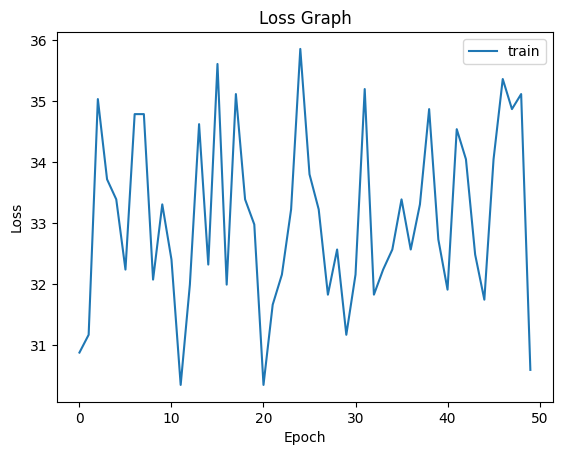

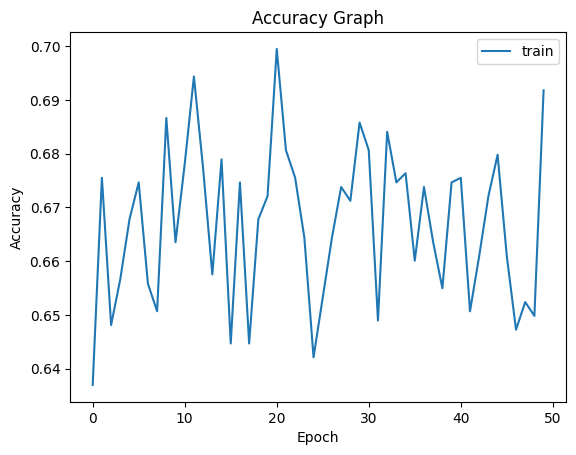

In [24]:
# Function to plot loss and accuracy
def plot_metrics(train, val=None, name1="train", name2="val", title=""):
    plt.figure()
    plt.title(title)
    plt.plot(train, label=name1)
    if val is not None:
        plt.plot(val, label=name2)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(title.split()[0])  # Use "Loss" or "Accuracy" as y-label
    plt.show()

# Plot loss and accuracy
plot_metrics(train_loss, title="Loss Graph")
plot_metrics(train_accuracy, title="Accuracy Graph")